In [1]:
# using CUDA
using DataFrames
using Flux
import JSON
using Lathe.preprocess: TrainTestSplit
using LinearAlgebra
using Plots
using StatsBase
using StatsPlots

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 1 method)

## Getting data together

In [2]:
# get data
x_df = DataFrame(
    CORX=Float64[],
    CORY=Float64[],
    I0=Float64[],
    K1Q1=Float64[],
    K1Q2=Float64[],
    SIGT=Float64[],
    SIGX=Float64[],
    SIGY=Float64[]
)
y_df = DataFrame(
    DE=Float64[],
    EMIT_X=Float64[],
    EMIT_Y=Float64[],
    REF_Z=Float64[],
    RMS_S=Float64[],
    RMS_X=Float64[],
    RMS_Y=Float64[]
)

x_df, y_df = readjsonsfromdirectory("../data/fodo-data-varying-magnets", x_df, y_df);
select!(y_df, Not(:REF_Z)) # drops column with same value

,DE,EMIT_X,EMIT_Y,RMS_S,RMS_X,RMS_Y
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.347318,0.000925985,0.0017946,0.0823494,0.0883698,0.143761
2,0.356681,0.0238754,0.0449889,0.248859,0.210266,0.227137
3,0.345005,0.000399035,0.00125149,0.101194,0.0509243,0.147673
4,0.31572,0.0155924,0.0269114,0.143957,0.17436,0.126484
5,0.356962,0.0121983,0.00809451,0.0969926,0.17315,0.0441277
6,0.329402,0.00621294,0.007622,0.107611,0.20426,0.131031
7,0.336624,0.0324849,0.0245787,0.160253,0.231167,0.127048
8,0.348897,0.00916889,0.038088,0.189809,0.17789,0.187348
9,0.339085,0.00034144,0.00658782,0.0681621,0.0455235,0.211649


In [3]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [4]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [5]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [6]:
# build the model
x_dimension = length(names(x_df))
y_dimension = length(names(y_df))

function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [7]:
# organizing data into batches
batchsize = 32
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batchsize, shuffle=true);

# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

loss (generic function with 1 method)

Let's start training. Note that we can make the training process more explicit by unpacking what's under the hood of `Flux.train!(loss, Flux.params(m), data_loader, optimizer)`:

```julia
function trainmodel!(m, data_loader; epochs=epochs)
    for epoch = 1:n_epochs
        for d in data_loader
            gs = gradient(Flux.params(m)) do
                l = loss(d...)
            end
            Flux.update!(opt, Flux.params(m), gs)
        end
    end
end

trainmodel!(m, data_loader; epochs=n_epochs)
```

In [8]:
# training
n_epochs = 10000
training_losses = Float64[]
epochs = Int64[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=7.650310212107316
epoch 2, loss=7.778310274553506
epoch 3, loss=7.600830380026374
epoch 4, loss=7.586652766604377
epoch 5, loss=7.589824643679612
epoch 6, loss=7.5963344844882545
epoch 7, loss=7.544482947551552
epoch 8, loss=7.617485405065285
epoch 9, loss=7.132377086912507
epoch 10, loss=5.841762919468297
epoch 11, loss=3.5369579352101774
epoch 12, loss=2.9948340261606146
epoch 13, loss=2.9415715382335392
epoch 14, loss=2.904094651703109
epoch 15, loss=2.874595111138884
epoch 16, loss=2.819588764132203
epoch 17, loss=2.8038710381825838
epoch 18, loss=2.784795817222177
epoch 19, loss=2.676463204321977
epoch 20, loss=2.5777994144373526
epoch 21, loss=2.428391916130189
epoch 22, loss=2.0342766202667715
epoch 23, loss=1.548184510088589
epoch 24, loss=1.3621467821318036
epoch 25, loss=1.2971021859606375
epoch 26, loss=1.2678931396699777
epoch 27, loss=1.2484380115634532
epoch 28, loss=1.2330789642213977
epoch 29, loss=1.2203536695106108
epoch 30, loss=1.226961905482119
epoch 

epoch 240, loss=0.14983831519484114
epoch 241, loss=0.16699787630292812
epoch 242, loss=0.15535508406022333
epoch 243, loss=0.15402043899228235
epoch 244, loss=0.15068118884965412
epoch 245, loss=0.1493054333686723
epoch 246, loss=0.14769110144226053
epoch 247, loss=0.1449980502243907
epoch 248, loss=0.15462089351130925
epoch 249, loss=0.15777744800998203
epoch 250, loss=0.14788047322146727
epoch 251, loss=0.1425658580937374
epoch 252, loss=0.15154714698705526
epoch 253, loss=0.14583607996561107
epoch 254, loss=0.1439496630465281
epoch 255, loss=0.1434123899357328
epoch 256, loss=0.14883213575628487
epoch 257, loss=0.14074310175573057
epoch 258, loss=0.1421933106482304
epoch 259, loss=0.15032680606872073
epoch 260, loss=0.13990801925977125
epoch 261, loss=0.14078101613488164
epoch 262, loss=0.14759727818741467
epoch 263, loss=0.13920099026837862
epoch 264, loss=0.1423301330900336
epoch 265, loss=0.14368606468528683
epoch 266, loss=0.1378776729598104
epoch 267, loss=0.146880007324765
ep

epoch 470, loss=0.03895628057110788
epoch 471, loss=0.03953573206605662
epoch 472, loss=0.036687881340886346
epoch 473, loss=0.03725572112402349
epoch 474, loss=0.038770120901849434
epoch 475, loss=0.041318296202606346
epoch 476, loss=0.042604026127245814
epoch 477, loss=0.038649383608155584
epoch 478, loss=0.0440862672959274
epoch 479, loss=0.03502693050856517
epoch 480, loss=0.03967010850529118
epoch 481, loss=0.037740827001791766
epoch 482, loss=0.0350016605637945
epoch 483, loss=0.037247392035455525
epoch 484, loss=0.045360089319644456
epoch 485, loss=0.03473146372884919
epoch 486, loss=0.035966559479202076
epoch 487, loss=0.03581246793769257
epoch 488, loss=0.03655453079842425
epoch 489, loss=0.03825987075345515
epoch 490, loss=0.03995396929157567
epoch 491, loss=0.04205696219001009
epoch 492, loss=0.03661221460356517
epoch 493, loss=0.03565804353191558
epoch 494, loss=0.03463601979729743
epoch 495, loss=0.03177539840911129
epoch 496, loss=0.039019924182076664
epoch 497, loss=0.03

epoch 695, loss=0.020559784029778785
epoch 696, loss=0.02077746861750483
epoch 697, loss=0.022199060214591892
epoch 698, loss=0.022863798649756305
epoch 699, loss=0.022281138843756994
epoch 700, loss=0.01994021874729924
epoch 701, loss=0.022335925532510396
epoch 702, loss=0.021544265274253117
epoch 703, loss=0.02031858902371651
epoch 704, loss=0.022983716402172956
epoch 705, loss=0.021307780297271945
epoch 706, loss=0.01795853655277707
epoch 707, loss=0.01900395737748301
epoch 708, loss=0.020094919217067568
epoch 709, loss=0.021319235951878943
epoch 710, loss=0.023466328802362813
epoch 711, loss=0.02764541847668847
epoch 712, loss=0.01964627521848165
epoch 713, loss=0.022484465542502156
epoch 714, loss=0.02362515584401946
epoch 715, loss=0.0187949292335318
epoch 716, loss=0.021284151447350585
epoch 717, loss=0.019274664963316295
epoch 718, loss=0.02086200128774408
epoch 719, loss=0.021479354432167634
epoch 720, loss=0.024138242634464433
epoch 721, loss=0.021009601348761894
epoch 722, l

epoch 920, loss=0.016697483840457293
epoch 921, loss=0.013652452555740706
epoch 922, loss=0.017089043364125943
epoch 923, loss=0.015554405442033053
epoch 924, loss=0.01364554551746664
epoch 925, loss=0.013136453312646899
epoch 926, loss=0.012509515718841692
epoch 927, loss=0.014120327973495366
epoch 928, loss=0.013961965183624074
epoch 929, loss=0.014786246418773342
epoch 930, loss=0.016087900312325217
epoch 931, loss=0.015487860683637009
epoch 932, loss=0.013912737588853648
epoch 933, loss=0.013623932325695162
epoch 934, loss=0.014239942104788947
epoch 935, loss=0.01382486647425723
epoch 936, loss=0.013954232172059475
epoch 937, loss=0.01398416550280239
epoch 938, loss=0.013347334941219252
epoch 939, loss=0.013935228713539237
epoch 940, loss=0.015553046917590827
epoch 941, loss=0.01470232096994228
epoch 942, loss=0.01271658191922009
epoch 943, loss=0.013370086846997323
epoch 944, loss=0.013760519283601481
epoch 945, loss=0.018373287241172223
epoch 946, loss=0.01545678462535292
epoch 9

epoch 1140, loss=0.011015476853161742
epoch 1141, loss=0.010218439226225808
epoch 1142, loss=0.0173050278230741
epoch 1143, loss=0.011786821859545547
epoch 1144, loss=0.011183838196649875
epoch 1145, loss=0.01148976220250426
epoch 1146, loss=0.010823852320867336
epoch 1147, loss=0.014054721654083504
epoch 1148, loss=0.010680279409158526
epoch 1149, loss=0.011591328146733738
epoch 1150, loss=0.010880830861634603
epoch 1151, loss=0.010321225646572677
epoch 1152, loss=0.011158806913797482
epoch 1153, loss=0.011076832461357813
epoch 1154, loss=0.010489134797978732
epoch 1155, loss=0.010498786628688118
epoch 1156, loss=0.011680384598685672
epoch 1157, loss=0.013056907216708947
epoch 1158, loss=0.012933456653815435
epoch 1159, loss=0.012348039943637725
epoch 1160, loss=0.014459818473518278
epoch 1161, loss=0.012218139289832983
epoch 1162, loss=0.01283651009877882
epoch 1163, loss=0.017226891298114985
epoch 1164, loss=0.010283552094797938
epoch 1165, loss=0.010819083480625486
epoch 1166, loss

epoch 1360, loss=0.010182963936411549
epoch 1361, loss=0.008244713837126204
epoch 1362, loss=0.008733258760932155
epoch 1363, loss=0.009926812741047982
epoch 1364, loss=0.009894042575510508
epoch 1365, loss=0.009012474075944537
epoch 1366, loss=0.010052481952532907
epoch 1367, loss=0.010666124684413724
epoch 1368, loss=0.008550161822280446
epoch 1369, loss=0.008484109146519467
epoch 1370, loss=0.010766352237278544
epoch 1371, loss=0.007937208690379442
epoch 1372, loss=0.0076990876351864385
epoch 1373, loss=0.008502396769002104
epoch 1374, loss=0.009202122772064811
epoch 1375, loss=0.008492135585737706
epoch 1376, loss=0.009375738771289416
epoch 1377, loss=0.009932463716186616
epoch 1378, loss=0.009209841053925258
epoch 1379, loss=0.010346558430098761
epoch 1380, loss=0.009614812302380706
epoch 1381, loss=0.008965875446918022
epoch 1382, loss=0.008920156537366573
epoch 1383, loss=0.009249631028899787
epoch 1384, loss=0.010965052296371508
epoch 1385, loss=0.008242451991637659
epoch 1386,

epoch 1580, loss=0.006503370719303824
epoch 1581, loss=0.009597928331805786
epoch 1582, loss=0.006492295537713821
epoch 1583, loss=0.009826335188035277
epoch 1584, loss=0.009145814105788812
epoch 1585, loss=0.008538596769737792
epoch 1586, loss=0.007441551910926614
epoch 1587, loss=0.007420825040903332
epoch 1588, loss=0.007967517407873268
epoch 1589, loss=0.00799654610605031
epoch 1590, loss=0.00882164698359335
epoch 1591, loss=0.00750473336790651
epoch 1592, loss=0.007470167584272819
epoch 1593, loss=0.009051374573672832
epoch 1594, loss=0.011270829109896545
epoch 1595, loss=0.007326059401992913
epoch 1596, loss=0.007130578332013807
epoch 1597, loss=0.007866221920901974
epoch 1598, loss=0.007663173041625675
epoch 1599, loss=0.007656262654009612
epoch 1600, loss=0.00728177995295857
epoch 1601, loss=0.00815021814028767
epoch 1602, loss=0.007037981849073569
epoch 1603, loss=0.008477563394166795
epoch 1604, loss=0.007107124818649181
epoch 1605, loss=0.010564556057568512
epoch 1606, loss=

epoch 1797, loss=0.00586344069833718
epoch 1798, loss=0.006577982951274504
epoch 1799, loss=0.007373385932486994
epoch 1800, loss=0.008565407416464032
epoch 1801, loss=0.007274740004948777
epoch 1802, loss=0.006230104539624609
epoch 1803, loss=0.005810724023780664
epoch 1804, loss=0.007445025894545378
epoch 1805, loss=0.007748609187287023
epoch 1806, loss=0.006068239366283553
epoch 1807, loss=0.00789353920156025
epoch 1808, loss=0.005825776416309341
epoch 1809, loss=0.009214652810075415
epoch 1810, loss=0.008683760171817037
epoch 1811, loss=0.007827686350184939
epoch 1812, loss=0.007035317489133619
epoch 1813, loss=0.00794079765363573
epoch 1814, loss=0.007229807175504865
epoch 1815, loss=0.006628975956044251
epoch 1816, loss=0.006740799161318123
epoch 1817, loss=0.0066790640165955645
epoch 1818, loss=0.00799967883864034
epoch 1819, loss=0.006819672003370933
epoch 1820, loss=0.00941975169523794
epoch 1821, loss=0.008329553990608507
epoch 1822, loss=0.006845192226984808
epoch 1823, loss

epoch 2013, loss=0.0065605506490660406
epoch 2014, loss=0.005921631498195713
epoch 2015, loss=0.0064132934168970555
epoch 2016, loss=0.005117036799013483
epoch 2017, loss=0.005506312797055226
epoch 2018, loss=0.0049965061833818014
epoch 2019, loss=0.006284416298911553
epoch 2020, loss=0.005169661357079844
epoch 2021, loss=0.005048431769674992
epoch 2022, loss=0.005832862898507119
epoch 2023, loss=0.008654512734472241
epoch 2024, loss=0.0059924556943360425
epoch 2025, loss=0.005511976244039159
epoch 2026, loss=0.005376017224030007
epoch 2027, loss=0.00535410636274651
epoch 2028, loss=0.0062315442570358755
epoch 2029, loss=0.006270273115166973
epoch 2030, loss=0.006218174616757924
epoch 2031, loss=0.006018951258481862
epoch 2032, loss=0.0064675788584263
epoch 2033, loss=0.006277048456289235
epoch 2034, loss=0.005557056131661511
epoch 2035, loss=0.005211568803428712
epoch 2036, loss=0.005929605637026997
epoch 2037, loss=0.005183193159381914
epoch 2038, loss=0.0052797741228286605
epoch 203

epoch 2232, loss=0.004612483924758539
epoch 2233, loss=0.004882721075343934
epoch 2234, loss=0.006088910237926421
epoch 2235, loss=0.004613900667888206
epoch 2236, loss=0.005859449221147299
epoch 2237, loss=0.005092011971002979
epoch 2238, loss=0.00455329764667022
epoch 2239, loss=0.006354536179836623
epoch 2240, loss=0.0050139815132888566
epoch 2241, loss=0.004878033144790952
epoch 2242, loss=0.005927598092678361
epoch 2243, loss=0.0052594445343967094
epoch 2244, loss=0.005057471808820193
epoch 2245, loss=0.00738689019656218
epoch 2246, loss=0.005264741105710154
epoch 2247, loss=0.006007359084174063
epoch 2248, loss=0.007344408831799765
epoch 2249, loss=0.006272287080435306
epoch 2250, loss=0.005602483183694972
epoch 2251, loss=0.004721298946631541
epoch 2252, loss=0.0049248608428234895
epoch 2253, loss=0.006900115625465453
epoch 2254, loss=0.008010954385393903
epoch 2255, loss=0.004665662441428426
epoch 2256, loss=0.006873431680734556
epoch 2257, loss=0.004590394786830721
epoch 2258,

epoch 2451, loss=0.004816631343956839
epoch 2452, loss=0.004496665831254691
epoch 2453, loss=0.006493343965218163
epoch 2454, loss=0.0041641979463789445
epoch 2455, loss=0.005566927971590488
epoch 2456, loss=0.00488715691854535
epoch 2457, loss=0.00407887583742399
epoch 2458, loss=0.004080328782437121
epoch 2459, loss=0.004802093831244194
epoch 2460, loss=0.004926688520826409
epoch 2461, loss=0.005997095812750094
epoch 2462, loss=0.004793540641091132
epoch 2463, loss=0.0042475489709576705
epoch 2464, loss=0.004244458788699929
epoch 2465, loss=0.005104290862350807
epoch 2466, loss=0.006291895674042564
epoch 2467, loss=0.0059815455255161154
epoch 2468, loss=0.006321990633899786
epoch 2469, loss=0.004515787704148938
epoch 2470, loss=0.006353498795691496
epoch 2471, loss=0.01019481932630634
epoch 2472, loss=0.004724725755990238
epoch 2473, loss=0.0050586167312612895
epoch 2474, loss=0.005220209144972256
epoch 2475, loss=0.004238188962382504
epoch 2476, loss=0.004985772619601626
epoch 2477,

epoch 2668, loss=0.004498926617155246
epoch 2669, loss=0.004797971692070288
epoch 2670, loss=0.004403920181793817
epoch 2671, loss=0.004234792357233933
epoch 2672, loss=0.004167606708524585
epoch 2673, loss=0.004896993599321508
epoch 2674, loss=0.004299563648360532
epoch 2675, loss=0.004237021136538741
epoch 2676, loss=0.003982215241904504
epoch 2677, loss=0.004458074187284387
epoch 2678, loss=0.0037058098241808143
epoch 2679, loss=0.004252684903868471
epoch 2680, loss=0.004234442766256346
epoch 2681, loss=0.0059621718089760975
epoch 2682, loss=0.004252457245124846
epoch 2683, loss=0.00449514272980167
epoch 2684, loss=0.0035488352718259994
epoch 2685, loss=0.004482561062802443
epoch 2686, loss=0.0035659322455728927
epoch 2687, loss=0.0041027388522888765
epoch 2688, loss=0.004097055836672031
epoch 2689, loss=0.004436944083842528
epoch 2690, loss=0.004102703900546006
epoch 2691, loss=0.0035186303714311116
epoch 2692, loss=0.005489629910645586
epoch 2693, loss=0.004138327940290699
epoch 2

epoch 2886, loss=0.004644482917768743
epoch 2887, loss=0.003609675872188925
epoch 2888, loss=0.0038604515404896535
epoch 2889, loss=0.0032117159926027946
epoch 2890, loss=0.004036677305444669
epoch 2891, loss=0.003441582483660442
epoch 2892, loss=0.004416769956011776
epoch 2893, loss=0.00648426136237942
epoch 2894, loss=0.004868456941441024
epoch 2895, loss=0.0033046480201028732
epoch 2896, loss=0.003480657549707627
epoch 2897, loss=0.004387366485324293
epoch 2898, loss=0.00487601519071817
epoch 2899, loss=0.0035911687190882382
epoch 2900, loss=0.003659598418476755
epoch 2901, loss=0.0038870067800984673
epoch 2902, loss=0.0038435536397112124
epoch 2903, loss=0.0047285221868122495
epoch 2904, loss=0.004665216746208301
epoch 2905, loss=0.0034583900446381577
epoch 2906, loss=0.0038601743020160338
epoch 2907, loss=0.0031726243232567414
epoch 2908, loss=0.0031779904799865656
epoch 2909, loss=0.004040581440549379
epoch 2910, loss=0.004164519404703045
epoch 2911, loss=0.00482011426605822
epoc

epoch 3101, loss=0.0035036289401050285
epoch 3102, loss=0.003358547190104471
epoch 3103, loss=0.003266439369777156
epoch 3104, loss=0.003910166184899392
epoch 3105, loss=0.0035030612057082187
epoch 3106, loss=0.0038881970428840066
epoch 3107, loss=0.006044670661705792
epoch 3108, loss=0.003290268199064528
epoch 3109, loss=0.0041660846595611535
epoch 3110, loss=0.003496356398924631
epoch 3111, loss=0.0036506314386681674
epoch 3112, loss=0.00361186595265711
epoch 3113, loss=0.004307554314008738
epoch 3114, loss=0.0034546552424194418
epoch 3115, loss=0.003385040218558718
epoch 3116, loss=0.004648617616848416
epoch 3117, loss=0.003688403209007132
epoch 3118, loss=0.0042353132728605815
epoch 3119, loss=0.003463529925000163
epoch 3120, loss=0.0033920124354335905
epoch 3121, loss=0.003492995634844635
epoch 3122, loss=0.0029475936815760283
epoch 3123, loss=0.0030613951979762445
epoch 3124, loss=0.003223366937211661
epoch 3125, loss=0.004176860749298707
epoch 3126, loss=0.003464552321953112
epo

epoch 3318, loss=0.003591348695698894
epoch 3319, loss=0.004687189793343864
epoch 3320, loss=0.002933998046381174
epoch 3321, loss=0.003338300321197767
epoch 3322, loss=0.0032500260019153646
epoch 3323, loss=0.004266118003723183
epoch 3324, loss=0.002915357627458554
epoch 3325, loss=0.003188509231386042
epoch 3326, loss=0.0034234147416518147
epoch 3327, loss=0.003106674498386055
epoch 3328, loss=0.0030024256910998037
epoch 3329, loss=0.0028417605604365687
epoch 3330, loss=0.003079668606035049
epoch 3331, loss=0.003512442179118236
epoch 3332, loss=0.004226331769702398
epoch 3333, loss=0.0033897889262930695
epoch 3334, loss=0.004479877468299207
epoch 3335, loss=0.0028231646170146863
epoch 3336, loss=0.00354992762970449
epoch 3337, loss=0.00416534605322498
epoch 3338, loss=0.005166960296685695
epoch 3339, loss=0.006012071229330347
epoch 3340, loss=0.003119280055386815
epoch 3341, loss=0.003172482016278156
epoch 3342, loss=0.0027198115801138584
epoch 3343, loss=0.0027334312693377623
epoch 

epoch 3535, loss=0.0029976864906225286
epoch 3536, loss=0.0028599149601957717
epoch 3537, loss=0.0025640819573323
epoch 3538, loss=0.002981288014769485
epoch 3539, loss=0.0038263813014833216
epoch 3540, loss=0.0033637322259073626
epoch 3541, loss=0.003208584673845559
epoch 3542, loss=0.0033506564204657313
epoch 3543, loss=0.0031938042515602433
epoch 3544, loss=0.003043635445946329
epoch 3545, loss=0.0032269438632660276
epoch 3546, loss=0.0027020726196434757
epoch 3547, loss=0.0029591289891593093
epoch 3548, loss=0.0034114886506467277
epoch 3549, loss=0.0028326480640546207
epoch 3550, loss=0.005998079737848233
epoch 3551, loss=0.0030552357092473916
epoch 3552, loss=0.003640874669829555
epoch 3553, loss=0.003150256487374135
epoch 3554, loss=0.0029905967145125723
epoch 3555, loss=0.0029771509646425425
epoch 3556, loss=0.003137717915548587
epoch 3557, loss=0.0034829816981209317
epoch 3558, loss=0.003650618899640256
epoch 3559, loss=0.003094038861480359
epoch 3560, loss=0.004110590696859054

epoch 3750, loss=0.002737094720900811
epoch 3751, loss=0.0027565170617926266
epoch 3752, loss=0.00244215865126494
epoch 3753, loss=0.0023789929640541164
epoch 3754, loss=0.002791711527973059
epoch 3755, loss=0.004503533304022788
epoch 3756, loss=0.002946477412841425
epoch 3757, loss=0.0037777734720753882
epoch 3758, loss=0.002927647147435692
epoch 3759, loss=0.0026428489878780226
epoch 3760, loss=0.002604536666567434
epoch 3761, loss=0.002734569014965219
epoch 3762, loss=0.0026100384084350435
epoch 3763, loss=0.003925976633656078
epoch 3764, loss=0.0039609194646856045
epoch 3765, loss=0.0027518022523273502
epoch 3766, loss=0.003594738585449015
epoch 3767, loss=0.0026525763106572085
epoch 3768, loss=0.002633996839290432
epoch 3769, loss=0.002984677035607484
epoch 3770, loss=0.0027050633052054527
epoch 3771, loss=0.002574261061858862
epoch 3772, loss=0.003617060540926401
epoch 3773, loss=0.0028800847791309162
epoch 3774, loss=0.00433673254479525
epoch 3775, loss=0.003207555513619187
epoc

epoch 3967, loss=0.002479031491274082
epoch 3968, loss=0.002664577675071122
epoch 3969, loss=0.0023192483746449486
epoch 3970, loss=0.002351300232355716
epoch 3971, loss=0.004753671029765869
epoch 3972, loss=0.003465361143405208
epoch 3973, loss=0.0030675715642623155
epoch 3974, loss=0.0026903738200283853
epoch 3975, loss=0.0030540507427963045
epoch 3976, loss=0.002446916874206232
epoch 3977, loss=0.0032914270655229694
epoch 3978, loss=0.002369670720597329
epoch 3979, loss=0.0040237935267598965
epoch 3980, loss=0.0023509221354123997
epoch 3981, loss=0.0030975525851730315
epoch 3982, loss=0.0026115215671526897
epoch 3983, loss=0.0032669343291490557
epoch 3984, loss=0.0022638417195239044
epoch 3985, loss=0.0030262513681826456
epoch 3986, loss=0.002965610611598862
epoch 3987, loss=0.003391131998109544
epoch 3988, loss=0.005302175295190855
epoch 3989, loss=0.0030263553875897803
epoch 3990, loss=0.0026745787993948116
epoch 3991, loss=0.0029737942066013845
epoch 3992, loss=0.0022771662013183

epoch 4181, loss=0.0024216700051038777
epoch 4182, loss=0.0022226381397057434
epoch 4183, loss=0.0030552974204513684
epoch 4184, loss=0.0027243679727156325
epoch 4185, loss=0.0026742604220710182
epoch 4186, loss=0.0030630380857891186
epoch 4187, loss=0.002369457006302401
epoch 4188, loss=0.003061112749136647
epoch 4189, loss=0.002407789350792492
epoch 4190, loss=0.002916173495417043
epoch 4191, loss=0.0025814312323059656
epoch 4192, loss=0.0032076602238525487
epoch 4193, loss=0.002475050791474812
epoch 4194, loss=0.0027534802618913085
epoch 4195, loss=0.002304092591509485
epoch 4196, loss=0.0024753211264180305
epoch 4197, loss=0.00205589301233739
epoch 4198, loss=0.002915451414106875
epoch 4199, loss=0.005831965948587919
epoch 4200, loss=0.002910696645009764
epoch 4201, loss=0.0026092413420532854
epoch 4202, loss=0.0026884197619152788
epoch 4203, loss=0.002095352715024821
epoch 4204, loss=0.0023881953191902776
epoch 4205, loss=0.0021909701471009074
epoch 4206, loss=0.00225805712967468


epoch 4397, loss=0.0026796877789475736
epoch 4398, loss=0.00226780005051988
epoch 4399, loss=0.002418735381641953
epoch 4400, loss=0.0021308948436180902
epoch 4401, loss=0.002095416916193893
epoch 4402, loss=0.004670961294835811
epoch 4403, loss=0.003292797339727047
epoch 4404, loss=0.0021670639104695
epoch 4405, loss=0.002585176513609648
epoch 4406, loss=0.0027271197387333653
epoch 4407, loss=0.0025094302984002568
epoch 4408, loss=0.003046807002052126
epoch 4409, loss=0.003213128026931811
epoch 4410, loss=0.004364643850209943
epoch 4411, loss=0.0025958111534685993
epoch 4412, loss=0.001971844458129936
epoch 4413, loss=0.0027362032916973195
epoch 4414, loss=0.002090288953779857
epoch 4415, loss=0.002632883908602166
epoch 4416, loss=0.0018834877920597094
epoch 4417, loss=0.002102959952479641
epoch 4418, loss=0.003039935881208937
epoch 4419, loss=0.004223403295897344
epoch 4420, loss=0.0022325532578769043
epoch 4421, loss=0.0021798193195126095
epoch 4422, loss=0.0019243915666557131
epoch

epoch 4613, loss=0.002486348344119075
epoch 4614, loss=0.0028841270458003936
epoch 4615, loss=0.002575570705803642
epoch 4616, loss=0.002449053091835488
epoch 4617, loss=0.001661279104388472
epoch 4618, loss=0.0023276625687924848
epoch 4619, loss=0.002301628012020547
epoch 4620, loss=0.002358225640644295
epoch 4621, loss=0.00208178347145257
epoch 4622, loss=0.001982720732464717
epoch 4623, loss=0.00286177110165458
epoch 4624, loss=0.002237637528800254
epoch 4625, loss=0.0019862928596736038
epoch 4626, loss=0.0025348779656611873
epoch 4627, loss=0.0021686830092020846
epoch 4628, loss=0.0036697900561230177
epoch 4629, loss=0.0025855758333716773
epoch 4630, loss=0.0019575590931967
epoch 4631, loss=0.0018644527435596463
epoch 4632, loss=0.002095852066452692
epoch 4633, loss=0.0021680145505376777
epoch 4634, loss=0.0020547398973750396
epoch 4635, loss=0.002476987383616008
epoch 4636, loss=0.003332246952786296
epoch 4637, loss=0.003556790833514265
epoch 4638, loss=0.0022637383273255395
epoch

epoch 4829, loss=0.001717216014229247
epoch 4830, loss=0.001974136309437641
epoch 4831, loss=0.002354939935631951
epoch 4832, loss=0.0036054037395041936
epoch 4833, loss=0.002617041841073904
epoch 4834, loss=0.0017799105251987547
epoch 4835, loss=0.0021853617402665974
epoch 4836, loss=0.0017926440108079352
epoch 4837, loss=0.0019623746204554173
epoch 4838, loss=0.0025894976931413447
epoch 4839, loss=0.002121835352942642
epoch 4840, loss=0.0019084413701738693
epoch 4841, loss=0.0027717106038589543
epoch 4842, loss=0.0016976818561965398
epoch 4843, loss=0.002298688564271055
epoch 4844, loss=0.0018225337954297643
epoch 4845, loss=0.0030844826845616174
epoch 4846, loss=0.0019123924765588368
epoch 4847, loss=0.0019992897300358963
epoch 4848, loss=0.0018379449771321504
epoch 4849, loss=0.003320631905240566
epoch 4850, loss=0.002773726761259545
epoch 4851, loss=0.0034768871191518925
epoch 4852, loss=0.0031842191728982563
epoch 4853, loss=0.002727419298994751
epoch 4854, loss=0.002253897635804

epoch 5046, loss=0.002685322641094951
epoch 5047, loss=0.002687656958425792
epoch 5048, loss=0.002311346678624414
epoch 5049, loss=0.0020320050648958395
epoch 5050, loss=0.002248213959376971
epoch 5051, loss=0.001939986832413317
epoch 5052, loss=0.0019237402510407157
epoch 5053, loss=0.0017641806207685689
epoch 5054, loss=0.002137873624868165
epoch 5055, loss=0.0018272586118460229
epoch 5056, loss=0.0020416764615989497
epoch 5057, loss=0.0019446492391540359
epoch 5058, loss=0.001915033408997242
epoch 5059, loss=0.0020752657228076295
epoch 5060, loss=0.0016732430450615127
epoch 5061, loss=0.0015390305074476968
epoch 5062, loss=0.002149208235972719
epoch 5063, loss=0.0024955657916988787
epoch 5064, loss=0.0020702808978736442
epoch 5065, loss=0.0016000831936058711
epoch 5066, loss=0.0029994753067170863
epoch 5067, loss=0.002639445878261376
epoch 5068, loss=0.0015656782530363844
epoch 5069, loss=0.001915625676173472
epoch 5070, loss=0.002690366508712925
epoch 5071, loss=0.00194178575227166

epoch 5262, loss=0.0018441516320925882
epoch 5263, loss=0.0024498866102558273
epoch 5264, loss=0.0022264415339931032
epoch 5265, loss=0.00164204658270555
epoch 5266, loss=0.001644007368449762
epoch 5267, loss=0.002396599857497347
epoch 5268, loss=0.0018803677217664589
epoch 5269, loss=0.002659352444928202
epoch 5270, loss=0.0018187640416124124
epoch 5271, loss=0.0017366085536873656
epoch 5272, loss=0.002198155882006095
epoch 5273, loss=0.0018902461788979563
epoch 5274, loss=0.0017707824733299922
epoch 5275, loss=0.002160600132635921
epoch 5276, loss=0.0019944552334041094
epoch 5277, loss=0.0016809932435049608
epoch 5278, loss=0.002251531779447607
epoch 5279, loss=0.001929002413357004
epoch 5280, loss=0.002090027011151359
epoch 5281, loss=0.0019242789209081648
epoch 5282, loss=0.0029986054945301275
epoch 5283, loss=0.0025798459954165047
epoch 5284, loss=0.0022896719032939787
epoch 5285, loss=0.0025536213364119103
epoch 5286, loss=0.001802315300536514
epoch 5287, loss=0.00151335270539833

epoch 5476, loss=0.0017329852760581148
epoch 5477, loss=0.0016046515443896257
epoch 5478, loss=0.0016566298938581918
epoch 5479, loss=0.0017287755646040264
epoch 5480, loss=0.002322299372070914
epoch 5481, loss=0.0016342007920711196
epoch 5482, loss=0.0017844945259367611
epoch 5483, loss=0.0021366082654803082
epoch 5484, loss=0.0017338293215150113
epoch 5485, loss=0.0016629202800039957
epoch 5486, loss=0.002005470618098192
epoch 5487, loss=0.0018827777056778627
epoch 5488, loss=0.0017899200788446547
epoch 5489, loss=0.002054496449954808
epoch 5490, loss=0.0018640192901753854
epoch 5491, loss=0.0019922644475975654
epoch 5492, loss=0.001954503454033605
epoch 5493, loss=0.0016333856689931983
epoch 5494, loss=0.00213625575933472
epoch 5495, loss=0.0021354953831123897
epoch 5496, loss=0.001779183039803085
epoch 5497, loss=0.0016831720744703098
epoch 5498, loss=0.0019477906461548978
epoch 5499, loss=0.0023304338355584686
epoch 5500, loss=0.0019410658215691268
epoch 5501, loss=0.0025070390080

epoch 5692, loss=0.0015026554337372103
epoch 5693, loss=0.0037607447446690893
epoch 5694, loss=0.0024705085272102908
epoch 5695, loss=0.0018039590759994395
epoch 5696, loss=0.0015838825081148336
epoch 5697, loss=0.0021739256455893764
epoch 5698, loss=0.0016786058573953517
epoch 5699, loss=0.0026224435925712004
epoch 5700, loss=0.0018126657347690743
epoch 5701, loss=0.002449486795285137
epoch 5702, loss=0.0015449332284404194
epoch 5703, loss=0.0030017994611808156
epoch 5704, loss=0.002029801459612788
epoch 5705, loss=0.0015210090498038972
epoch 5706, loss=0.0018784798563160393
epoch 5707, loss=0.0022665032386220084
epoch 5708, loss=0.002609735186255579
epoch 5709, loss=0.001870685170687738
epoch 5710, loss=0.0020703933208205197
epoch 5711, loss=0.00174144957210937
epoch 5712, loss=0.0018360552954134572
epoch 5713, loss=0.0014330870285528775
epoch 5714, loss=0.002321795195931941
epoch 5715, loss=0.0027944631666650508
epoch 5716, loss=0.0021002986300012396
epoch 5717, loss=0.0015636021123

epoch 5903, loss=0.0017068114433730155
epoch 5904, loss=0.0027736914385101245
epoch 5905, loss=0.002077331618196908
epoch 5906, loss=0.0012479984549669304
epoch 5907, loss=0.0018208539795875078
epoch 5908, loss=0.0020888190598717217
epoch 5909, loss=0.001934950716636949
epoch 5910, loss=0.001441219751482301
epoch 5911, loss=0.0016229753416361985
epoch 5912, loss=0.0017584365058483248
epoch 5913, loss=0.001768599779619729
epoch 5914, loss=0.002008994578448538
epoch 5915, loss=0.0013313398891222016
epoch 5916, loss=0.0012797402036291098
epoch 5917, loss=0.001456768344001382
epoch 5918, loss=0.001402369505486466
epoch 5919, loss=0.0024836144172217436
epoch 5920, loss=0.001472931647600813
epoch 5921, loss=0.0020450200627102344
epoch 5922, loss=0.0015475791332615393
epoch 5923, loss=0.0016486374749604237
epoch 5924, loss=0.0030616816298383483
epoch 5925, loss=0.002170689460266787
epoch 5926, loss=0.0017931427122791343
epoch 5927, loss=0.0019596036487139826
epoch 5928, loss=0.002497422415925

epoch 6118, loss=0.0015779437933508007
epoch 6119, loss=0.0016759956936677892
epoch 6120, loss=0.0015469385368081059
epoch 6121, loss=0.0018494294346911393
epoch 6122, loss=0.00224675744439767
epoch 6123, loss=0.001998562278373251
epoch 6124, loss=0.0017990693773730034
epoch 6125, loss=0.0019857396927276173
epoch 6126, loss=0.0013913232391341674
epoch 6127, loss=0.0019289383847669692
epoch 6128, loss=0.0017894262471054342
epoch 6129, loss=0.0016602000113600823
epoch 6130, loss=0.0014663250491842223
epoch 6131, loss=0.0017319679533523444
epoch 6132, loss=0.005771483096276492
epoch 6133, loss=0.0017999847395537376
epoch 6134, loss=0.001404087662432792
epoch 6135, loss=0.001296448205688441
epoch 6136, loss=0.0022034898879702528
epoch 6137, loss=0.0016875122663835365
epoch 6138, loss=0.002066658236717272
epoch 6139, loss=0.0020134379321302583
epoch 6140, loss=0.001261513817337416
epoch 6141, loss=0.001555520307638151
epoch 6142, loss=0.0014441434180699827
epoch 6143, loss=0.001179736447579

epoch 6333, loss=0.0015746779005522192
epoch 6334, loss=0.0012940725341142468
epoch 6335, loss=0.0017223775937649018
epoch 6336, loss=0.0015772043790108364
epoch 6337, loss=0.0013969117560881368
epoch 6338, loss=0.001516879873427114
epoch 6339, loss=0.0015660859435436337
epoch 6340, loss=0.0019594234679337877
epoch 6341, loss=0.0014269985826439679
epoch 6342, loss=0.0013884045258101133
epoch 6343, loss=0.003368419188620162
epoch 6344, loss=0.00275910292026766
epoch 6345, loss=0.0015796318421157562
epoch 6346, loss=0.001506796276423258
epoch 6347, loss=0.0015737631191609235
epoch 6348, loss=0.0012830271395002965
epoch 6349, loss=0.0021489723555531324
epoch 6350, loss=0.0018372135732761087
epoch 6351, loss=0.0013217730915080384
epoch 6352, loss=0.0015546790806133862
epoch 6353, loss=0.0015091616775266441
epoch 6354, loss=0.0019974547377491526
epoch 6355, loss=0.0016970331392187489
epoch 6356, loss=0.0021301615324667072
epoch 6357, loss=0.002623842666176745
epoch 6358, loss=0.003254631610

epoch 6548, loss=0.0012733703323648542
epoch 6549, loss=0.0014127682911251114
epoch 6550, loss=0.0013247426528875468
epoch 6551, loss=0.0014451562752985038
epoch 6552, loss=0.0012471154789123133
epoch 6553, loss=0.0011784171293389518
epoch 6554, loss=0.0012092652758884468
epoch 6555, loss=0.0013535672317097874
epoch 6556, loss=0.0014562455099898326
epoch 6557, loss=0.0014185106985674454
epoch 6558, loss=0.0015098378416272262
epoch 6559, loss=0.002402588951573209
epoch 6560, loss=0.00212424810892025
epoch 6561, loss=0.001543867203136847
epoch 6562, loss=0.0013799786703797094
epoch 6563, loss=0.0014184739894880938
epoch 6564, loss=0.0014516762330803797
epoch 6565, loss=0.0014508689234783918
epoch 6566, loss=0.0018092750537881915
epoch 6567, loss=0.0013731268953983214
epoch 6568, loss=0.0012993966470396837
epoch 6569, loss=0.0016701374609942156
epoch 6570, loss=0.0013157646949533421
epoch 6571, loss=0.0013177196430783497
epoch 6572, loss=0.0013440643950892396
epoch 6573, loss=0.0014942708

epoch 6763, loss=0.0016343633501369349
epoch 6764, loss=0.0011412678686112596
epoch 6765, loss=0.0014358490615817843
epoch 6766, loss=0.0015071996355541881
epoch 6767, loss=0.001144494449687495
epoch 6768, loss=0.001192554197267032
epoch 6769, loss=0.0012753353143680729
epoch 6770, loss=0.001070211939147646
epoch 6771, loss=0.001164909002681651
epoch 6772, loss=0.0013568309428471058
epoch 6773, loss=0.0011260832287307296
epoch 6774, loss=0.0017335657743491125
epoch 6775, loss=0.0017414165911932404
epoch 6776, loss=0.0017063192003683744
epoch 6777, loss=0.0018384361027536068
epoch 6778, loss=0.002019975792381242
epoch 6779, loss=0.0018166521116376535
epoch 6780, loss=0.0016192003406772873
epoch 6781, loss=0.0013872141960266729
epoch 6782, loss=0.0013946071746602391
epoch 6783, loss=0.0012179783467937571
epoch 6784, loss=0.0012088986322648686
epoch 6785, loss=0.0014621249776233594
epoch 6786, loss=0.0013461227814209394
epoch 6787, loss=0.0015743521178456683
epoch 6788, loss=0.00151817312

epoch 6978, loss=0.0011841684519347606
epoch 6979, loss=0.001492616292972343
epoch 6980, loss=0.0014723732346827725
epoch 6981, loss=0.0024267039558344135
epoch 6982, loss=0.00113970316337672
epoch 6983, loss=0.0014400410555544965
epoch 6984, loss=0.001121119630508567
epoch 6985, loss=0.0010434510943680064
epoch 6986, loss=0.0012117606807738478
epoch 6987, loss=0.0018479731352237412
epoch 6988, loss=0.001363138968164863
epoch 6989, loss=0.001535899032615102
epoch 6990, loss=0.0013395443536706854
epoch 6991, loss=0.0014052338294085643
epoch 6992, loss=0.0016058872821032278
epoch 6993, loss=0.0012454442097553891
epoch 6994, loss=0.0011627638722862062
epoch 6995, loss=0.0012148957897481249
epoch 6996, loss=0.0013772530026705454
epoch 6997, loss=0.0013825153849335381
epoch 6998, loss=0.0019251377647866142
epoch 6999, loss=0.0019074352540361427
epoch 7000, loss=0.002387526145104895
epoch 7001, loss=0.0019889262329432023
epoch 7002, loss=0.0019584257948445823
epoch 7003, loss=0.0015769075243

epoch 7190, loss=0.0012754004231195686
epoch 7191, loss=0.0010699505233353573
epoch 7192, loss=0.0011803356271970072
epoch 7193, loss=0.0011682320867092216
epoch 7194, loss=0.0011407834948440013
epoch 7195, loss=0.0022772885247415897
epoch 7196, loss=0.0010578474832850565
epoch 7197, loss=0.0016535968908848917
epoch 7198, loss=0.001574440081264426
epoch 7199, loss=0.0014857062394178985
epoch 7200, loss=0.001446416384182246
epoch 7201, loss=0.0013396715985377248
epoch 7202, loss=0.0015445945732581337
epoch 7203, loss=0.0011285739873922393
epoch 7204, loss=0.0012648303726587075
epoch 7205, loss=0.0013540206418857217
epoch 7206, loss=0.0012928276561684413
epoch 7207, loss=0.0021583890606371855
epoch 7208, loss=0.001139378874351293
epoch 7209, loss=0.0014708892297306715
epoch 7210, loss=0.0012381056527828096
epoch 7211, loss=0.0015634283361202744
epoch 7212, loss=0.001505567607452297
epoch 7213, loss=0.0013107624147390092
epoch 7214, loss=0.0008968750432077233
epoch 7215, loss=0.0013256114

epoch 7406, loss=0.0016093513733202302
epoch 7407, loss=0.001117816638030913
epoch 7408, loss=0.0017376428504657004
epoch 7409, loss=0.001418396713737282
epoch 7410, loss=0.001242517184951494
epoch 7411, loss=0.0009562474065282558
epoch 7412, loss=0.0010812972661874709
epoch 7413, loss=0.00113093726940091
epoch 7414, loss=0.0013437957720817896
epoch 7415, loss=0.0014368684065594866
epoch 7416, loss=0.000996397033777171
epoch 7417, loss=0.0010472292629003352
epoch 7418, loss=0.0012061836913342552
epoch 7419, loss=0.0009236824678309771
epoch 7420, loss=0.0012564265029510087
epoch 7421, loss=0.0015412597466785952
epoch 7422, loss=0.001394280044316999
epoch 7423, loss=0.002256884293645332
epoch 7424, loss=0.0014953957289742157
epoch 7425, loss=0.0021938658695019385
epoch 7426, loss=0.0012413102828539467
epoch 7427, loss=0.0015514851964470683
epoch 7428, loss=0.0010180416482942166
epoch 7429, loss=0.0011840415845754742
epoch 7430, loss=0.0010377379875279953
epoch 7431, loss=0.00155003238808

epoch 7621, loss=0.0017009872973810425
epoch 7622, loss=0.001130634875848209
epoch 7623, loss=0.0026239783311362407
epoch 7624, loss=0.0017854181532231672
epoch 7625, loss=0.0013022827453862038
epoch 7626, loss=0.0010110172149878243
epoch 7627, loss=0.0011106984296511127
epoch 7628, loss=0.0009250904012513823
epoch 7629, loss=0.0014160515623093148
epoch 7630, loss=0.0014782105317591744
epoch 7631, loss=0.0016159909613304305
epoch 7632, loss=0.0017454738950471295
epoch 7633, loss=0.001380486407050843
epoch 7634, loss=0.0010275253897310873
epoch 7635, loss=0.0010300006088096408
epoch 7636, loss=0.0010113143659685737
epoch 7637, loss=0.0012376891781109736
epoch 7638, loss=0.0017083281195315082
epoch 7639, loss=0.0016277381592187008
epoch 7640, loss=0.0010274033020683823
epoch 7641, loss=0.0014095779012736702
epoch 7642, loss=0.001181566467354174
epoch 7643, loss=0.0013299815262201129
epoch 7644, loss=0.001530984090025482
epoch 7645, loss=0.0016385436018743172
epoch 7646, loss=0.0021127719

epoch 7834, loss=0.0020447354222273067
epoch 7835, loss=0.0015599284902916098
epoch 7836, loss=0.0014758191010352045
epoch 7837, loss=0.0009142886087648962
epoch 7838, loss=0.0008222726886696574
epoch 7839, loss=0.0009379932282442618
epoch 7840, loss=0.001314883032154106
epoch 7841, loss=0.0011544230970380355
epoch 7842, loss=0.0011365907083444613
epoch 7843, loss=0.00118730226681231
epoch 7844, loss=0.001046374946004609
epoch 7845, loss=0.0014038632626516396
epoch 7846, loss=0.0013138513372179012
epoch 7847, loss=0.0008629434806838443
epoch 7848, loss=0.0013597337244719001
epoch 7849, loss=0.0012709305444803486
epoch 7850, loss=0.0010892323037346614
epoch 7851, loss=0.0010267436993916601
epoch 7852, loss=0.0013878639476351078
epoch 7853, loss=0.001536375221065762
epoch 7854, loss=0.0030578847933802568
epoch 7855, loss=0.0018976780608665918
epoch 7856, loss=0.002612455673769916
epoch 7857, loss=0.002481307885476567
epoch 7858, loss=0.0012431254820284472
epoch 7859, loss=0.0009565707541

epoch 8049, loss=0.0012122856745026508
epoch 8050, loss=0.002166334008453806
epoch 8051, loss=0.0013167305097439386
epoch 8052, loss=0.0014439053759587445
epoch 8053, loss=0.0011626357683403516
epoch 8054, loss=0.0011105090286960477
epoch 8055, loss=0.0014307057358013257
epoch 8056, loss=0.0011104368750571032
epoch 8057, loss=0.0019595020800067895
epoch 8058, loss=0.0012576172262451423
epoch 8059, loss=0.000938968458378276
epoch 8060, loss=0.0014918806549215206
epoch 8061, loss=0.0009976878298983188
epoch 8062, loss=0.0012754013166015312
epoch 8063, loss=0.0012524890384703019
epoch 8064, loss=0.0016177957676303718
epoch 8065, loss=0.0012726510200158222
epoch 8066, loss=0.0010068987951574128
epoch 8067, loss=0.0011556565911507593
epoch 8068, loss=0.0011193333761695295
epoch 8069, loss=0.0011785469844542028
epoch 8070, loss=0.0010976247182469922
epoch 8071, loss=0.0009593435129785208
epoch 8072, loss=0.001049235381703397
epoch 8073, loss=0.0011341616798235365
epoch 8074, loss=0.001108535

epoch 8261, loss=0.0009271740849769761
epoch 8262, loss=0.0010720211025605187
epoch 8263, loss=0.0012400177656942762
epoch 8264, loss=0.0012844612112793716
epoch 8265, loss=0.0013624550976604555
epoch 8266, loss=0.0009624693237792339
epoch 8267, loss=0.0011262721676064498
epoch 8268, loss=0.0016442512928310162
epoch 8269, loss=0.001101832548854386
epoch 8270, loss=0.000903623187863489
epoch 8271, loss=0.0013204644109393068
epoch 8272, loss=0.0009483788357108726
epoch 8273, loss=0.0012011893271817778
epoch 8274, loss=0.0015702056091523354
epoch 8275, loss=0.0016156641639576634
epoch 8276, loss=0.0008422679281773299
epoch 8277, loss=0.0009062457174225319
epoch 8278, loss=0.0012501201586403619
epoch 8279, loss=0.0010465683250696256
epoch 8280, loss=0.00132578564246967
epoch 8281, loss=0.0009521923083570329
epoch 8282, loss=0.0015136011752158282
epoch 8283, loss=0.0011756303701478431
epoch 8284, loss=0.0013494101998609055
epoch 8285, loss=0.0017462713416352684
epoch 8286, loss=0.0010501555

epoch 8476, loss=0.0012205209645903955
epoch 8477, loss=0.0013803176401867014
epoch 8478, loss=0.0013348396190095014
epoch 8479, loss=0.0011871682715570075
epoch 8480, loss=0.0012045949385048227
epoch 8481, loss=0.001437558749837551
epoch 8482, loss=0.0015137925588944421
epoch 8483, loss=0.0009996103649506439
epoch 8484, loss=0.001348821444480616
epoch 8485, loss=0.0021821713685774395
epoch 8486, loss=0.001193005451842987
epoch 8487, loss=0.0009053342142854698
epoch 8488, loss=0.0010330472406282231
epoch 8489, loss=0.0008288198476194031
epoch 8490, loss=0.0008848921572963668
epoch 8491, loss=0.000904014869103258
epoch 8492, loss=0.000976125577494152
epoch 8493, loss=0.0008615138190788979
epoch 8494, loss=0.0015102275080983935
epoch 8495, loss=0.0014039676875150723
epoch 8496, loss=0.0011898480074198764
epoch 8497, loss=0.001028301521376841
epoch 8498, loss=0.000973754846486406
epoch 8499, loss=0.0009467418529583949
epoch 8500, loss=0.0009781640034512687
epoch 8501, loss=0.0010524315236

epoch 8687, loss=0.001034665796654087
epoch 8688, loss=0.0011975298717759925
epoch 8689, loss=0.0009650264735871549
epoch 8690, loss=0.0012105653062605968
epoch 8691, loss=0.0014135322646538337
epoch 8692, loss=0.0010204593000361446
epoch 8693, loss=0.00080591584409026
epoch 8694, loss=0.001136825860944471
epoch 8695, loss=0.0009886381795404552
epoch 8696, loss=0.0009839505607869418
epoch 8697, loss=0.0009235205883908637
epoch 8698, loss=0.0011378239888363598
epoch 8699, loss=0.0011544738144510691
epoch 8700, loss=0.0015697779952693553
epoch 8701, loss=0.0011682541409454982
epoch 8702, loss=0.0013493944286563772
epoch 8703, loss=0.0017214762364146108
epoch 8704, loss=0.0012616033985089075
epoch 8705, loss=0.0011685375248874912
epoch 8706, loss=0.0009756029016663978
epoch 8707, loss=0.0011235491914079634
epoch 8708, loss=0.0008373463260922609
epoch 8709, loss=0.0013630497553068141
epoch 8710, loss=0.001556996410693611
epoch 8711, loss=0.0008082833096677087
epoch 8712, loss=0.00082702569

epoch 8901, loss=0.00105438241459066
epoch 8902, loss=0.0008743432039560503
epoch 8903, loss=0.001286144563803062
epoch 8904, loss=0.0035167277757765154
epoch 8905, loss=0.0012627872934563892
epoch 8906, loss=0.0009207331266945445
epoch 8907, loss=0.0013282996054402379
epoch 8908, loss=0.0009041784236603822
epoch 8909, loss=0.0010108112705081295
epoch 8910, loss=0.0014490316830283573
epoch 8911, loss=0.0011146860485175697
epoch 8912, loss=0.00197977710682222
epoch 8913, loss=0.0011946056867595456
epoch 8914, loss=0.0019174508682921108
epoch 8915, loss=0.0010586072231302708
epoch 8916, loss=0.0010961420794697438
epoch 8917, loss=0.0009581018559390984
epoch 8918, loss=0.0009717482234166126
epoch 8919, loss=0.000844717019674825
epoch 8920, loss=0.0009411624685628382
epoch 8921, loss=0.0012503333792317243
epoch 8922, loss=0.001041362767453483
epoch 8923, loss=0.0007788837471263702
epoch 8924, loss=0.000818911521271373
epoch 8925, loss=0.0008588915909326378
epoch 8926, loss=0.00142551385253

epoch 9116, loss=0.0011941809616648562
epoch 9117, loss=0.0008374212608205648
epoch 9118, loss=0.0011163391226777632
epoch 9119, loss=0.0008168228341348832
epoch 9120, loss=0.0009823048799894492
epoch 9121, loss=0.001527866482149492
epoch 9122, loss=0.0008121988267903049
epoch 9123, loss=0.0010483171443863453
epoch 9124, loss=0.0009353527027641795
epoch 9125, loss=0.0013835974552984822
epoch 9126, loss=0.0011749547733367943
epoch 9127, loss=0.0014816891749432073
epoch 9128, loss=0.001217895320410371
epoch 9129, loss=0.0010980625319620052
epoch 9130, loss=0.0009036740082777154
epoch 9131, loss=0.0010206613521583827
epoch 9132, loss=0.0013704778997366655
epoch 9133, loss=0.0017323076184780886
epoch 9134, loss=0.0010540788877233859
epoch 9135, loss=0.001618766222115897
epoch 9136, loss=0.002420153447026053
epoch 9137, loss=0.0023342829869064646
epoch 9138, loss=0.0011885553627084134
epoch 9139, loss=0.0012300098020293722
epoch 9140, loss=0.0009902726703402622
epoch 9141, loss=0.0009538017

epoch 9329, loss=0.0008022413209621402
epoch 9330, loss=0.000782992417745033
epoch 9331, loss=0.0012374740616400567
epoch 9332, loss=0.0011839969961771563
epoch 9333, loss=0.001050474352648609
epoch 9334, loss=0.001237586685817801
epoch 9335, loss=0.0006877168723307894
epoch 9336, loss=0.0007089393154723805
epoch 9337, loss=0.0010297643505170573
epoch 9338, loss=0.0013478117491019515
epoch 9339, loss=0.001579170003169431
epoch 9340, loss=0.0010426346676686853
epoch 9341, loss=0.0011240227621205378
epoch 9342, loss=0.0007972351933480721
epoch 9343, loss=0.001038979508865842
epoch 9344, loss=0.0010158564362828001
epoch 9345, loss=0.0008287769943208051
epoch 9346, loss=0.0012261100387637562
epoch 9347, loss=0.0012178565914731181
epoch 9348, loss=0.0010930874864067096
epoch 9349, loss=0.0009110490411038592
epoch 9350, loss=0.0017996843099346137
epoch 9351, loss=0.0017153026982640168
epoch 9352, loss=0.001095860160733776
epoch 9353, loss=0.000830251742126197
epoch 9354, loss=0.0007974454719

epoch 9543, loss=0.0008689468161051986
epoch 9544, loss=0.0011244441412233059
epoch 9545, loss=0.0008725175449208576
epoch 9546, loss=0.0008078187950514669
epoch 9547, loss=0.0010896651785562844
epoch 9548, loss=0.0009080374909855682
epoch 9549, loss=0.0009698511232245383
epoch 9550, loss=0.0010071182381677054
epoch 9551, loss=0.0019290986568431447
epoch 9552, loss=0.0026999244720902556
epoch 9553, loss=0.001264212684707376
epoch 9554, loss=0.0012429288498024098
epoch 9555, loss=0.001107710725990022
epoch 9556, loss=0.000844961937777392
epoch 9557, loss=0.0009189126833167553
epoch 9558, loss=0.0009753252218473998
epoch 9559, loss=0.001105047999180774
epoch 9560, loss=0.0013230387961035036
epoch 9561, loss=0.0010177906183266331
epoch 9562, loss=0.0008199902984945221
epoch 9563, loss=0.0007647811743833208
epoch 9564, loss=0.000791287023928667
epoch 9565, loss=0.0011686094752201921
epoch 9566, loss=0.0007665624887461673
epoch 9567, loss=0.0007985159291603292
epoch 9568, loss=0.00091959357

epoch 9760, loss=0.0009926512017948079
epoch 9761, loss=0.0013663142134914335
epoch 9762, loss=0.0009852201343056623
epoch 9763, loss=0.0007182500868050097
epoch 9764, loss=0.0009273008928170313
epoch 9765, loss=0.0007013341571586638
epoch 9766, loss=0.0008612190748523768
epoch 9767, loss=0.0009932260281261727
epoch 9768, loss=0.0007866630107496485
epoch 9769, loss=0.0007080621649734432
epoch 9770, loss=0.0009110248658088226
epoch 9771, loss=0.0009471447164024472
epoch 9772, loss=0.0011417691019439066
epoch 9773, loss=0.0009787438981486416
epoch 9774, loss=0.0006826610787154471
epoch 9775, loss=0.0009737304311448841
epoch 9776, loss=0.0012392116902453535
epoch 9777, loss=0.0010043462915699409
epoch 9778, loss=0.0019828434322142186
epoch 9779, loss=0.0033600875351131702
epoch 9780, loss=0.0019176321896905077
epoch 9781, loss=0.0018595757009962416
epoch 9782, loss=0.0009563323308052919
epoch 9783, loss=0.000954141579098047
epoch 9784, loss=0.0009728888631788579
epoch 9785, loss=0.0006787

epoch 9973, loss=0.0010554769298905605
epoch 9974, loss=0.00116377855963728
epoch 9975, loss=0.0017666543204946136
epoch 9976, loss=0.0008651153956575083
epoch 9977, loss=0.0011775808311581587
epoch 9978, loss=0.0013276426005442241
epoch 9979, loss=0.000762119248650909
epoch 9980, loss=0.0009341428655593573
epoch 9981, loss=0.0011103682521305907
epoch 9982, loss=0.001248487961578696
epoch 9983, loss=0.0008382939481599846
epoch 9984, loss=0.000909462928023742
epoch 9985, loss=0.0011067686900300459
epoch 9986, loss=0.0007175177587876184
epoch 9987, loss=0.000788013967855688
epoch 9988, loss=0.0010351747770187636
epoch 9989, loss=0.000987629405062835
epoch 9990, loss=0.0008278689100697551
epoch 9991, loss=0.0008856690025801947
epoch 9992, loss=0.0009273096199560523
epoch 9993, loss=0.0008284326658312555
epoch 9994, loss=0.0009555045690384854
epoch 9995, loss=0.0009925374424076898
epoch 9996, loss=0.0008416444091203791
epoch 9997, loss=0.0008654152847303612
epoch 9998, loss=0.0010255114346

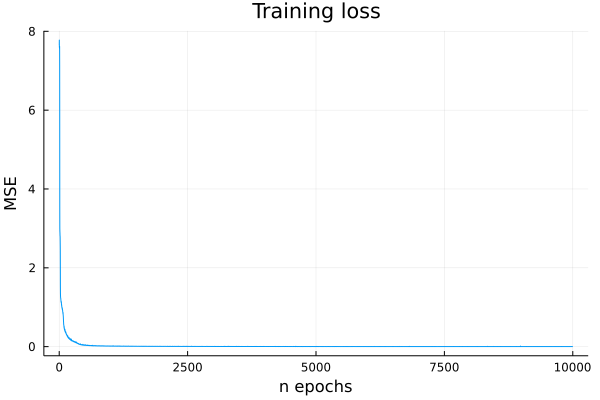

In [9]:
# plot the results
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

I define a function to compute $R^2$ for multidimensional target variables `r2score_multidim`, with similar functionality to <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html'>`sklearn.metrics.r2_score`</a>:
- `multioutput="rawvalues"` computes the $R^2$ score for each of the dimensions separately, returning a vector
- `multioutput="uniformaverage"` computes the $R^2$ score for each of the dimensions of the output separately, and averages the result uniformly
- (**TODO**) `multioutput="varianceweighted"` computes the $R^2$ score for each of the dimensions of the output separately, and then computes a weighted average with weights equal to the variance of each of the output dimensions. _This isn't needed just yet so I'll wait on implementing this_

In [10]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [11]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9997185472522978
r2 on test set: 0.9944340687758658


Recall that we can express the adjusted $R^2$, $\bar{R}^2$ in terms of our sample size $M$ and the dimensions of our input $p$:

$$ \bar{R}^2 = 1 - (1 - R^2) \frac{M - 1}{M - p - 1} $$

This extends our implementation of `r2score` and `r2score_multidim` easily.

In [12]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [13]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9997167061877174
adjustedr2 on test set: 0.9942851475390997


In [14]:
y_train_preds = m(x_train')';
y_test_preds = m(x_test')';

In [15]:
# mapes
function unscaled_mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    fit!(y_scaler, y_df[!, names(y_df)[i]])
    
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for $(names(y_df)[i]): ", unscaled_mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for DE: 0.008499943814715959
MAPE on test set for EMIT_X: 0.0737208593447791
MAPE on test set for EMIT_Y: 0.09042383034113335
MAPE on test set for RMS_S: 0.018133407483537513
MAPE on test set for RMS_X: 0.015422890858420796
MAPE on test set for RMS_Y: 0.029500681356347546


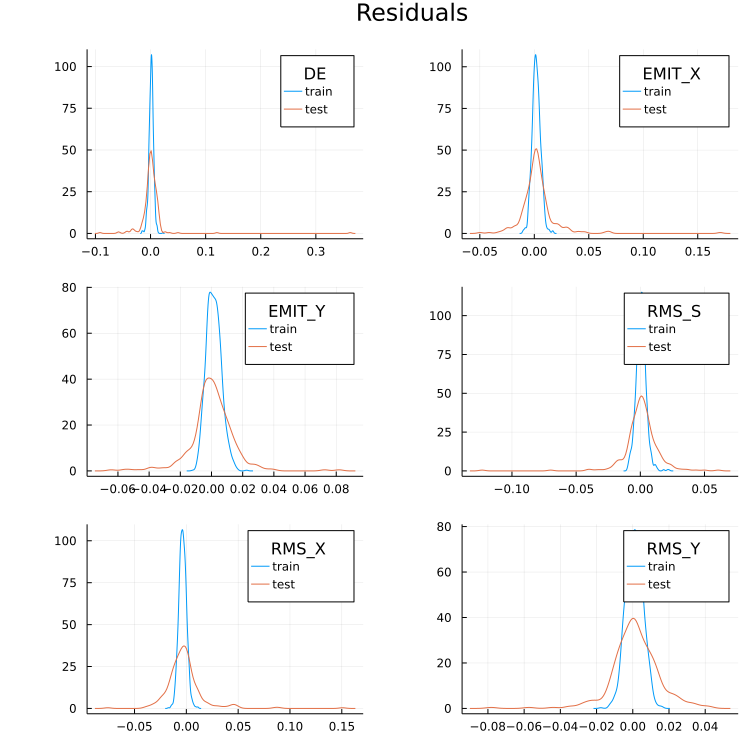

In [16]:
# plotting the residual distribution
l = @layout [grid(3,2)]
y_columns = names(y_df)
residuals_train = y_train - y_train_preds
residuals_test = y_test - y_test_preds

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")